# Homework2:模型優化

說明:以下是一個簡易的使用cnn進行CIFAR-10資料集的實作

* 請基於以下的code完成作業，epoch最多可以調整到15，**若超過扣50分**
* 此作業專注在課堂上提到的優化技巧，請在不調整epoch以外的原本超參數設定的情況下(刪減卷積層數量、神經元數量、batch size等等)完成模型的優化,**若調整扣50分**
* 請使用Data Augmentation、L1 or L2 Regularization、Dropout和Batch Normalization、EarlyStopping的方法來完成
* 可以自行調整L1 or L2 Regularization、Dropout和Batch Normalization的參數
* 請不要刪除文字說明,**違者-10分**
* 若同學的實作方法跟我們提供的順序不一樣的話，請詳細說明在哪個區塊實作，以避免扣分
* 請同學善用markdown或是註解來標示出自己的實作方法，以利批改

In [56]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [58]:
# 使用隨機種子
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(1)  # 固定隨機種子，不可更改

1.Data Augmentation(20分)

In [59]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 轉換為 Tensor
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
        transforms.RandomCrop(32, padding=4),  # 隨機裁剪到32x32，並填充4像素
])
val_transform = transforms.Compose([
    transforms.ToTensor(),  # 轉換為 Tensor

])


In [60]:
# 加載 CIFAR-10 原始資料集
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 將訓練集拆分為新的訓練集和驗證集，並固定隨機種子
train_size = int(0.8 * len(trainset_full))  # 80% 作為訓練集
valid_size = len(trainset_full) - train_size  # 20% 作為驗證集
trainset, validset = torch.utils.data.random_split(trainset_full, [train_size, valid_size],
                                                   generator=torch.Generator().manual_seed(1))  # 固定隨機種子，不可更改

# 創建 DataLoader
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=100, shuffle=False, num_workers=2)

# 加載 CIFAR-10 測試集並創建 testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# print資料集的大小
print(f"原始訓練集大小: {len(trainset_full)}")
print(f"訓練集大小: {len(trainset)}")
print(f"驗證集大小: {len(validset)}")
print(f"測試集大小: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
原始訓練集大小: 50000
訓練集大小: 40000
驗證集大小: 10000
測試集大小: 10000


2.Dropout、Batch Normalization(40分)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 第一層卷積層
        self.bn1 = nn.BatchNorm2d(32)  # 卷積層1後加入 Batch Normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二層卷積層
        self.bn2 = nn.BatchNorm2d(64)  # 卷積層2後加入 Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)  # 池化層
        self.dropout = nn.Dropout(p=0.5)  # Dropout層，設置丟棄比例為 0.5 ,即每次訓練都會有50%的的神經元會被隨機關閉
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 全連接層1
        self.bn_fc = nn.BatchNorm1d(512)  # 全連接層後的 Batch Normalization
        self.fc2 = nn.Linear(512, 100)  # 全連接層2，對應100類

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 卷積1 + ReLU + 池化 + batchNorm
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 卷積2 + ReLU + 池化 + batchNorm
        x = x.view(-1, 64 * 8 * 8)  # 展平輸入
        x = F.relu(self.bn_fc(self.fc1(x)))  # 全連接層1 + ReLU + batchNorm
        x = self.dropout(x)  # 在第一個全連接層 fc1 的 ReLU 激活函數之後，使用 Dropout
        x = self.fc2(x)  # 全連接層2 (輸出100類)
        return x


3.L1 or L2 Regularization(20分)

In [62]:
import torch
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 檢查是否有 GPU 可用，否則使用 CPU

net = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()  # 交叉熵損失
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)  # Adam優化器 （將L2 regularization加入adam的weight_decay參數中）


4.完成EarlyStopping的設定，若5個EPOCH都沒有更好的結果，就停止訓練
(5分)

In [63]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0): # 5個 epoch沒有改善就停止訓練

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss): # 確保最佳模型留下
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        self.val_loss_min = val_loss







5.train_model增加EarlyStopping的判斷邏輯(5分)

In [64]:

class EarlyStopping: # 加入early stopping
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        self.val_loss_min = val_loss

def train_model(epochs, l1_lambda=0.0, patience=5, weight_decay=1e-4):
  # 改 train_model 加入 L1 、L2 (weight_decay 參數)regularizion 、Early Stopping
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)     # EarlyStopping 進行初始

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=weight_decay) # 在adam加入L2 regulariztion（weight_decay）



    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # 訓練過程
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            l1_loss = 0 # 加入L1
            for param in net.parameters():
                l1_loss += torch.sum(torch.abs(param))  # 計算 L1 懲罰項
            loss += l1_lambda * l1_loss  # 將 L1 加入到損失中


            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 記錄訓練集的損失和準確率
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 驗證集評估
        net.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for data in validloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(validloader)
        valid_accuracy = 100 * valid_correct / valid_total
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'[Epoch {epoch+1}/{epochs}] Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}% | Validation loss: {valid_loss:.4f}, Validation accuracy: {valid_accuracy:.2f}%')

        early_stopping(valid_loss) # Early Stopping 檢查
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('Finished Training')

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [65]:
def test_model():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the 10000 test images: {100 * correct / total:.2f}%')


In [66]:
def plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # 損失圖表
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 準確率圖表
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


[Epoch 1/5] Train loss: 0.7421, Train accuracy: 74.05% | Validation loss: 0.7496, Validation accuracy: 74.10%
Validation loss decreased (inf --> 0.749642). Saving model...
[Epoch 2/5] Train loss: 0.7302, Train accuracy: 74.69% | Validation loss: 0.7143, Validation accuracy: 75.36%
Validation loss decreased (0.749642 --> 0.714344). Saving model...
[Epoch 3/5] Train loss: 0.7211, Train accuracy: 74.85% | Validation loss: 0.7951, Validation accuracy: 72.66%
EarlyStopping counter: 1 out of 5
[Epoch 4/5] Train loss: 0.7119, Train accuracy: 75.39% | Validation loss: 0.7217, Validation accuracy: 75.59%
EarlyStopping counter: 2 out of 5
[Epoch 5/5] Train loss: 0.7045, Train accuracy: 75.43% | Validation loss: 0.7137, Validation accuracy: 75.62%
Validation loss decreased (0.714344 --> 0.713701). Saving model...
Finished Training


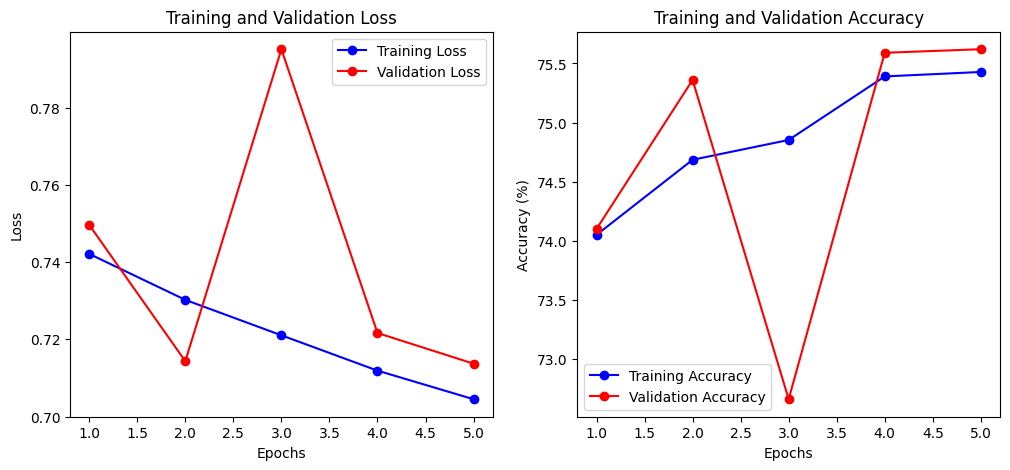

In [75]:
# 訓練模型並獲取損失與準確率
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(epochs=5)#epochs最多可以調整到15

# 繪製圖表
plot_metrics(train_losses, train_accuracies, valid_losses, valid_accuracies)

6.經過您改進的方法後,模型在測試集的Accuracy達到73.9%或以上(10分)

In [76]:
# 測試模型
test_model()

Accuracy on the 10000 test images: 75.54%
